## Assignment 1: Language Modeling

*This assignment is adapted from one created by David Gaddy, Daniel Fried, Nikita Kitaev, Mitchell Stern, Rodolfo Corona, John DeNero, and Dan Klein.*

TA contact for this assignment:
Sanxing Chen (sanxing.chen@duke.edu)


---



In this assignment, you will implement several different types of language models for text.  We'll start with n-gram models, then move on to neural n-gram and GRU language models.

**Warning**: Do not start this project the day before it is due!  Some parts require 20 minutes or more to run, so debugging and tuning can take a significant amount of time.

Our dataset for this project will be the WikiText2 language modeling dataset.  This dataset comes with some of the basic preprocessing done for us, such as tokenization and rare word filtering (using the `<unk>` token).
Therefore, we can assume that all word types in the test set also appear at least once in the training set.
We'll also use the Huggingface `datasets` and `tokenizers` libraries to help with some of the data preprocessing, such as converting tokens into id numbers.

**Note on GPU usage**: You will need to use a GPU for the neural n-gram and GRU models but **not** for the n-gram models. Colab places some restrictions on GPU usage due to which you might get locked out after continuously using one (~8 hours). To avoid this, you should only use the GPU when needed, i.e., on training and inference for the last two parts of this assignment. You can enable / disable GPU usage by changing the Runtime type under the Runtime menu.
If you do get locked out of using a GPU, a potential workaround is to sign in using a different account.

When training a model on the GPU it is also a good idea to save your model periodically in case you get locked out. You can use `torch.save(network.state_dict(), path)` and `network.load_state_dict()` for this; see [here](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html). You can also save your `*.npy` files to google drive to avoid lossing them after Colab session cut-off (see the sample script below).

```
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/CS572-S24-A1
!cp *.npy /content/drive/MyDrive/CS572-S24-A1
!ls /content/drive/MyDrive/CS572-S24-A1
```

**Grading rubric**
- 70% results
 - 15% bigram_predictions.npy (correctness)
 - 15% trigram_kn_predictions.npy (correctness)
 - 15% neural_trigram_predictions.npy (meets target)
 - 15% gru_predictions.npy (meets target)
 - 10% gru_predictions.npy (improvement over target)
  
- 30% writeup
 - 12.5% clarity
 - 12.5% correctness
 - 5% interestingness of ideas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd /content/drive/MyDrive/CS572-S24-A1

In [ ]:
!pwd

/content


In [ ]:
! ls
!cd drive/MyDrive/CS572-S24-A1/

drive  sample_data


In [ ]:
!pwd

/content


In [ ]:
!mkdir -p /content/drive/MyDrive/CS572-S24-A1
!cp *.npy /content/drive/MyDrive/CS572-S24-A1

cp: cannot stat '*.npy': No such file or directory


In [ ]:
!ls /content/drive/MyDrive/CS572-S24-A1

In [2]:
# Install some required packages.
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00


In [3]:
# This block handles some basic setup and data loading.
# You shouldn't need to edit this, but if you want to
# import other standard python packages, that is fine.

from collections import defaultdict, Counter
import numpy as np
import math
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F

# We'll use HuggingFace's datasets and tokenizers libraries, which are a bit
# heavy-duty for what we're doing, but it's worth getting to know them.

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import WhitespaceSplit

dataset = load_dataset("wikitext", "wikitext-2-v1")
tokenizer = Tokenizer(WordLevel(unk_token='<unk>'))
tokenizer.pre_tokenizer = WhitespaceSplit() # should be equivalent to split()

# "Training" a tokenizer below just feeds it all the tokens so it can map from
# word type to id.

trainer = WordLevelTrainer( # should only be 33,278 distinct types in Wikitext-2
    vocab_size=33300, special_tokens=["<unk>", "<eos>"])
generator_bsz = 512
all_splits_generator = (dataset[split][i:i+generator_bsz]["text"]
                        for split in ["train", "validation", "test"]
                          for i in range (0, len(dataset[split]), generator_bsz))
tokenizer.train_from_iterator(all_splits_generator, trainer)

# If desired, we could make a transformers tokenizer object now with:
# fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)

orig_vocab = tokenizer.get_vocab() # The tokenizer reserves a <pad> id, which we'll ignore.
word_types = sorted(list(orig_vocab.keys()), key=lambda w: orig_vocab[w]) # no <pad>
vocab = {w: i for i, w in enumerate(word_types)} # no <pad>
vocab_size = len(vocab)

# Make a single stream of tokens, with an <eos> after each newline.

train_text = []
for example in dataset["train"]["text"]:
  train_text.extend(tokenizer.encode(example).tokens + ["<eos>"])

validation_text = []
for example in dataset["validation"]["text"]:
  validation_text.extend(tokenizer.encode(example).tokens + ["<eos>"])

print(validation_text[:30])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

['<eos>', '=', 'Homarus', 'gammarus', '=', '<eos>', '<eos>', 'Homarus', 'gammarus', ',', 'known', 'as', 'the', 'European', 'lobster', 'or', 'common', 'lobster', ',', 'is', 'a', 'species', 'of', '<unk>', 'lobster', 'from', 'the', 'eastern', 'Atlantic', 'Ocean']


We've implemented a unigram model here as a demonstration.

In [4]:
class UnigramModel:
    def __init__(self, train_text):
        self.counts = Counter(train_text)
        self.total_count = len(train_text)

    def probability(self, word):
        return self.counts[word] / self.total_count

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""
        return [self.probability(word) for word in word_types]

    def perplexity(self, full_text):
        """Return the perplexity of the model on a text as a float.

        full_text -- a list of string tokens
        """
        log_probabilities = []
        for word in full_text:
            # Note that the base of the log doesn't matter
            # as long as the log and exp use the same base.
            log_probabilities.append(math.log(self.probability(word), 2))
        return 2 ** -np.mean(log_probabilities)

unigram_demonstration_model = UnigramModel(train_text)
print('unigram validation perplexity:',
      unigram_demonstration_model.perplexity(validation_text))

def check_validity(model):
    """Performs several sanity checks on your model:
    1) That next_word_probabilities returns a valid distribution
    2) That perplexity matches a perplexity calculated from next_word_probabilities

    Although it is possible to calculate perplexity from next_word_probabilities,
    it is still good to have a separate more efficient method that only computes
    the probabilities of observed words.
    """

    log_probabilities = []
    for i in range(10):
        prefix = validation_text[:i]
        probs = model.next_word_probabilities(prefix)
        assert min(probs) >= 0, "Negative value in next_word_probabilities"
        assert max(probs) <= 1 + 1e-8, "Value larger than 1 in next_word_probabilities"
        assert abs(sum(probs)-1) < 1e-4, "next_word_probabilities do not sum to 1"

        word_id = vocab[validation_text[i]]
        selected_prob = probs[word_id]
        log_probabilities.append(math.log(selected_prob))

    perplexity = math.exp(-np.mean(log_probabilities))
    your_perplexity = model.perplexity(validation_text[:10])
    assert abs(perplexity-your_perplexity) < 0.1, "your perplexity does not " + \
    "match the one we calculated from `next_word_probabilities`,\n" + \
    "at least one of `perplexity` or `next_word_probabilities` is incorrect.\n" + \
    f"we calcuated {perplexity} from `next_word_probabilities`,\n" + \
    f"but your perplexity function returned {your_perplexity} (on a small sample)."


check_validity(unigram_demonstration_model)

unigram validation perplexity: 965.0860734119312


To generate from a language model, we can sample one word at a time conditioning on the words we have generated so far.

In [5]:
def generate_text(model, n=20, prefix=('<eos>', '<eos>')):
    prefix = list(prefix)
    for _ in range(n):
        probs = model.next_word_probabilities(prefix)
        word = random.choices(word_types, probs)[0]
        prefix.append(word)
    return ' '.join(prefix)

print(generate_text(unigram_demonstration_model))

<eos> <eos> the , and Down ordered 2007 that 25 Caithness 18 his or sympathies R nationally much befriended in Tropical period


In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k words or sharpening the distribution with a temperature.  You can read more about sampling from a language model in this paper: https://arxiv.org/pdf/1904.09751.pdf.

You will need to submit some outputs from the models you implement for us to grade.  The following will download the required output files.

In [6]:
!gdown --id 1aHC9RfmeSa8dDwC9XGQN8uRmtTwJaIRw
!gdown --id 1oedI437UeS9AhUGwsC-PgBdD1sHOjhaY

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aHC9RfmeSa8dDwC9XGQN8uRmtTwJaIRw
To: /content/nu_eval_output_vocab_short.txt
100% 3.67k/3.67k [00:00<00:00, 17.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1oedI437UeS9AhUGwsC-PgBdD1sHOjhaY
To: /content/nu_eval_prefixes_short.txt
100% 104k/104k [00:00<00:00, 116MB/s]


In [7]:
def save_truncated_distribution(model, filename, short=True):
    """Generate a file of truncated distributions.

    Probability distributions over the full vocabulary are large,
    so we will truncate the distribution to a smaller vocabulary.

    Please do not edit this function
    """
    vocab_name = 'nu_eval_output_vocab'
    prefixes_name = 'nu_eval_prefixes'

    if short:
      vocab_name += '_short'
      prefixes_name += '_short'

    with open('{}.txt'.format(vocab_name), 'r') as eval_vocab_file:
        eval_vocab = [w.strip() for w in eval_vocab_file]
    eval_vocab_ids = [vocab[s] for s in eval_vocab]

    all_selected_probabilities = []
    with open('{}.txt'.format(prefixes_name), 'r') as eval_prefixes_file:
        lines = eval_prefixes_file.readlines()
        for line in tqdm.notebook.tqdm(lines, leave=False):
            prefix = line.strip().split(' ')
            probs = model.next_word_probabilities(prefix)
            selected_probs = np.array([probs[i] for i in eval_vocab_ids], dtype=np.float32)
            all_selected_probabilities.append(selected_probs)

    all_selected_probabilities = np.stack(all_selected_probabilities)
    np.save(filename, all_selected_probabilities)
    print('saved', filename)

In [ ]:
save_truncated_distribution(unigram_demonstration_model,
                            'unigram_demonstration_predictions.npy')

  0%|          | 0/1000 [00:00<?, ?it/s]

saved unigram_demonstration_predictions.npy


**Before you proceed**: At this point you should check whether you are able to upload the submission files to Gradescope. For this we will generate *dummy* prediction files by copying the unigram predictions above. Download the `unigrm_demonstration_predictions.npy` (you can do this by clicking the folder icon on left menu) and then copy this file and rename it to generate the required submision files:
* bigram_predictions.npy
* trigram_kn_predictions.npy
* neural_trigram_predictions.npy
* gru_predictions.npy

Also save a copy of this notebook as `proj_1.ipynb` and create a `report.pdf` (this can be empty for now). Upload these files to Gradescope and confirm that the autograder runs and produces an output score of 0.

### N-gram Model

Now it's time to implement an n-gram language model.

Because not every n-gram will have been observed in training, use add-alpha smoothing to make sure no output word has probability 0.

$$P(w_2|w_1)=\frac{\#(w_1,w_2)+\alpha}{\#(w_1)+V\alpha}$$

where $V$ is the vocab size and $\#()$ is the count for the given bigram.  An alpha value around `3e-3`  should work.  Later, we'll replace this smoothing with model backoff.

One edge case you will need to handle is at the beginning of the text where you don't have `n-1` prior words.  You can handle this however you like as long as you produce a valid probability distribution, but just using a uniform distribution over the vocabulary is reasonable for the purposes of this project.

A properly implemented bi-gram model should get a perplexity **below 505** on the validation set.

**Note**: Do not change the signature of the `next_word_probabilities` and `perplexity` functions.  We will use these as a common interface for all of the different model types.  Make sure these two functions call `n_gram_probability`, because later we are going to override `n_gram_probability` in a subclass.
Also, we suggest pre-computing and caching the counts $\#()$ when you initialize `NGramModel` for efficiency.

In [ ]:
class NGramModel:
    def __init__(self, train_text, n=2, alpha=3e-3):
        # get counts and perform any other setup
        self.n = n
        self.smoothing = alpha

        def generate_ngrams(text, n):
          ncounts = Counter()
          n_1counts = Counter()
          for i in range(len(text)-n+1):
              ngram = tuple(text[i:i+n])
              ncounts[ngram] += 1
          for i in range(len(text)-n+2):
              n_1gram = tuple(text[i:i+n-1])
              n_1counts[n_1gram] += 1
          return ncounts, n_1counts

        # YOUR CODE HERE
        self.counts, self.precounts = generate_ngrams(train_text, self.n)
        self.V = vocab_size
        assert self.V == len(set(train_text))


    def _to_string(self, tokens):
      return "_".join(tokens)

    def n_gram_probability(self, n_gram):
        """Return the probability of the last word in an n-gram.

        n_gram -- a list of string tokens
        returns the conditional probability of the last token given the rest.
        """
        assert len(n_gram) == self.n

        # YOUR CODE HERE

        num = self.counts[tuple(n_gram)] + self.smoothing
        den = self.precounts[tuple(n_gram[:-1])] + (self.smoothing * self.V)

        return num / den

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""

        # YOUR CODE HERE
        # use your function n_gram_probability
        # Recall word_types contains a list of words to return probabilities for

        probs = []
        if len(text_prefix) < self.n - 1:
            for word in word_types:
                prob = 1 / self.V
                probs.append(prob)
        else:
            prefix = text_prefix[len(text_prefix) - self.n+1 : ]
            for word in word_types:
                n_gram = tuple(prefix + [word])  # Combine prefix with the current word
                prob = self.n_gram_probability(n_gram)
                probs.append(prob)
        return probs

    def perplexity(self, full_text):
        """ full_text is a list of string tokens
        return perplexity as a float """

        # YOUR CODE HERE

        log_probabilities = []

        # Handle the special case (for the first n-1 words)
        for i in range(self.n - 1):
            n_gram = tuple(full_text[i])
            # Use Laplace smoothing for unseen n-grams
            log_probabilities.append(math.log(1 / self.V, 2))

        # Handle the general case (excluding the first n-1 words)
        for i in range(len(full_text) - self.n + 1):
            n_gram = tuple(full_text[i : i + self.n])
            # Calculate the log probability of the n-gram
            log_probabilities.append(math.log(self.n_gram_probability(n_gram), 2))

        pp = 2 ** -np.mean(log_probabilities)
        return pp
        # use your function n_gram_probability
        # This method should differ a bit from the example unigram model because
        # the first n-1 words of full_text must be handled as a special case.

unigram_model = NGramModel(train_text, n=1)
check_validity(unigram_model)
print('unigram validation perplexity:', unigram_model.perplexity(validation_text)) # this should be the almost the same as our unigram model perplexity above

bigram_model = NGramModel(train_text, n=2)
check_validity(bigram_model)
print('bigram validation perplexity:', bigram_model.perplexity(validation_text))

trigram_model = NGramModel(train_text, n=3)
check_validity(trigram_model)
print('trigram validation perplexity:', trigram_model.perplexity(validation_text)) # this won't do very well...

save_truncated_distribution(bigram_model, 'bigram_predictions.npy') # this might take a few minutes

unigram validation perplexity: 965.091829323117
bigram validation perplexity: 504.42630378506976
trigram validation perplexity: 2965.6042344003463


  0%|          | 0/1000 [00:00<?, ?it/s]

saved bigram_predictions.npy



Please download `bigram_predictions.npy` once you finish this section so that you can submit it.

In the block below, please report your bigram validation perplexity.  (We will use this to help us calibrate our scoring on the test set.)

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Bigram validation perplexity: 504.42630378506976

We can also generate samples from the model to get an idea of how it is doing.

In [ ]:
print(generate_text(bigram_model))

<eos> <eos> <eos> In historic 4000 Nogić insectivorous Condoms Muzaffar Fulk Hirosaki Takeshi varsity Bridgestone improvements amino acids aerodrome outfitted as "


We now free up some RAM, **it is important to run the cell below, otherwise you will likely run out of RAM in the Colab runtime.**

In [ ]:
# Free up some RAM.
del bigram_model
del trigram_model

This basic model works okay for bigrams, but a better strategy (especially for higher-order models) is to use backoff.  Implement backoff with absolute discounting.
$$P\left(w_i|h_i\right)=\frac{max\left\{\#(h_i, w_i)-d,0\right\}}{\#(h_i)} + \lambda(h_i) P(w_i|w_{i-n+2},\ldots, w_{i-1})$$

$$\lambda\left(h_i\right)=\frac{d N_{1+}(h_i)}{{\#(h_i)}}$$
where $h_i=(w_{i-n+1}, \ldots, w_{i-1})$ is the prefix before token $i$, $N_{1+}$ is the number of words that appear after the previous $n-1$ words (the number of times the max will select something other than 0 in the first equation).  If $\#(h_i)=0$, use the lower order model probability directly (the above equations would have a division by 0).

We found a discount $d$ of 0.9 to work well based on validation performance.  A trigram model with this discount value should get a validation perplexity below 272.

In [ ]:
class DiscountBackoffModel(NGramModel):
    def __init__(self, train_text, lower_order_model, n=2, delta=0.9):
        super().__init__(train_text, n=n)
        self.lower_order_model = lower_order_model
        self.discount = delta

        # YOUR CODE HERE
        following_words = defaultdict(set)
        for i in range(len(train_text) - n + 1):
            word = tuple(train_text[i:i+n-1])
            next_word = train_text[i+n-1]
            following_words[word].add(next_word)


        self.n1plus = {}

        for word, wc in following_words.items():
          self.n1plus[word] = len(wc)

    def n_gram_probability(self, n_gram):
        assert len(n_gram) == self.n

        # YOUR CODE HERE
        prefix = n_gram[:-1]
        count_ngram = self.counts[tuple(n_gram)]
        count_prefix = self.precounts[tuple(prefix)]
        lower_order = self.lower_order_model.n_gram_probability(n_gram[1:])
        if count_prefix == 0:
          return lower_order
        p_ngram = max(count_ngram - self.discount, 0) / count_prefix
        lambda_factor = (self.discount * self.n1plus[prefix]) / (count_prefix)

        p_ngram += (lambda_factor * lower_order)

        return p_ngram

bigram_backoff_model = DiscountBackoffModel(train_text, unigram_model, 2)
trigram_backoff_model = DiscountBackoffModel(train_text, bigram_backoff_model, 3)
check_validity(trigram_backoff_model)
print('trigram backoff validation perplexity:', trigram_backoff_model.perplexity(validation_text))

trigram backoff validation perplexity: 271.1218574337858


Free up RAM.

In [ ]:
# Release models we don't need any more.
del unigram_model
del bigram_backoff_model
del trigram_backoff_model

Now, implement Kneser-Ney to replace the unigram base model.
$$P(w)\propto |\{w':\#(w',w) > 0\}|$$
A Kneser-Ney trigram model should get a validation perplexity below 257.

In [ ]:
class KneserNeyBaseModel(NGramModel):
    def __init__(self, train_text):
        super().__init__(train_text, n=1)
        ubgs = defaultdict(set)
        for i in range(1, len(train_text)):
          pw = train_text[i-1]
          cw = train_text[i]
          ubgs[cw].add(pw)

        unique_endings = defaultdict(int)

        for w, wc in ubgs.items():
          unique_endings[w] = len(wc)
        tc = sum([wc for wc in unique_endings.values()])
        for w, wc in unique_endings.items():
          unique_endings[w] /= tc

        self.kn = unique_endings

    def n_gram_probability(self, n_gram):

        assert len(n_gram) == 1
        return self.kn[n_gram[0]]




kn_base = KneserNeyBaseModel(train_text)
check_validity(kn_base)
bigram_kn_backoff_model = DiscountBackoffModel(train_text, kn_base, 2)
trigram_kn_backoff_model = DiscountBackoffModel(train_text, bigram_kn_backoff_model, 3)
print('trigram Kneser-Ney backoff validation perplexity:', trigram_kn_backoff_model.perplexity(validation_text))

save_truncated_distribution(trigram_kn_backoff_model, 'trigram_kn_predictions.npy') # this might take a few minutes

trigram Kneser-Ney backoff validation perplexity: 256.61348380347727


  0%|          | 0/1000 [00:00<?, ?it/s]

saved trigram_kn_predictions.npy


In [ ]:
print(generate_text(trigram_kn_backoff_model))
print(generate_text(trigram_kn_backoff_model, prefix=['What','about']))

<eos> <eos> = = = = Critical reception of Zagreb in December 2013 , organizers , opening two of them such as
What about burned alive . The court venerated so long @-@ term production and young of the Panama Canal , and it


Fill in your trigram backoff perplexities with and without Kneser Ney.

<!-- Do not remove this comment, it is used by the

1.   List item
2.   List item

autograder: RqYJKsoTS6 -->

Trigram backoff validation perplexity: 271.1218574337858

Trigram backoff with Kneser Ney perplexity: 256.61348380347727

Free up RAM.

In [ ]:
# Delete models we don't need.
del kn_base
del bigram_kn_backoff_model
del trigram_kn_backoff_model

### Neural N-gram Model

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` words and outputs a distribution over the next word.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using PyTorch's data loaders (https://pytorch.org/docs/stable/data.html)

A model with the following architecture and hyperparameters should reach a validation perplexity **below or about 220**.
* embed the words with dimension 128, then flatten into a single embedding for $n-1$ words (with size $(n-1)*128$)
* run 2 hidden layers with 1024 hidden units, then project down to size 128 before the final layer (ie. 4 layers total).
* use weight tying for the embedding and final linear layer (this made a very large difference in our experiments); you can do this by creating the output layer with [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), then using [`F.embedding`](https://pytorch.org/docs/stable/generated/torch.nn.functional.embedding.html) with the linear layer's `.weight` to embed the input
* rectified linear activation (ReLU) and dropout 0.1 after first 2 hidden layers. **Note: You will likely find a performance drop if you add a nonlinear activation function after the dimension reduction layer.**
* train for 10 epochs with the Adam optimizer (should take around 15-20 minutes)
* do early stopping based on validation set perplexity (see Project 0)


We encourage you to try other architectures and hyperparameters, and you will likely find some that work better than the ones listed above.  A proper implementation with these should be enough to receive full credit on the assignment, although you might need to retrain the model for a few time.

In [12]:
import torch.optim as optim

def ids(tokens):
    return [vocab[t] for t in tokens]

assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

device = torch.device("cuda")

class NeuralNgramDataset(torch.utils.data.Dataset):
    def __init__(self, text_token_ids, n):
        self.text_token_ids = text_token_ids
        self.n = n

    def __len__(self):
        return len(self.text_token_ids)

    def __getitem__(self, i):
        if i < self.n-1:
            prev_token_ids = [vocab['<eos>']] * (self.n-i-1) + self.text_token_ids[:i]
        else:
            prev_token_ids = self.text_token_ids[i-self.n+1:i]

        assert len(prev_token_ids) == self.n-1

        x = torch.tensor(prev_token_ids)
        y = torch.tensor(self.text_token_ids[i])
        return x, y

class NeuralNGramNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self, n):
        super().__init__()


        # Initialize the different layers needed in the computation graph.
        # A full list of available layers in Pytorch is given here:
        # https://pytorch.org/docs/stable/nn.html
        # You will need linear and dropout layers only for this model.
        self.embed = nn.Embedding(vocab_size, 128)
        self.flatten = nn.Flatten(start_dim = 1)
        self.fcl1 = nn.Linear((n-1) * 128, 1024)
        self.fcl2 = nn.Linear(1024, 1024)
        self.fcl3 = nn.Linear(1024, 128)
        self.out = nn.Linear(128, vocab_size)
        self.drop = nn.Dropout(0.1)

        self.out.weight = self.embed.weight

        # An example on how to define neural networks in Pytorch is given here:
        # https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#define-the-network

        # YOUR CODE HERE

    def forward(self, x):
        # x is a tensor of inputs with shape (batch, n-1)
        # this function returns a tensor of log probabilities with shape (batch, vocab_size)

        # Run the input data through the network for a forward pass. See the
        # tutorial above on how to use the layers to construct a forward pass.

        # You can use a non-linear activation function from the list here:
        # https://pytorch.org/docs/stable/nn.functional.html

        # To convert the scores of the network into log-probabilities you can use
        # the log-softmax function:
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax

        # YOUR CODE HERE

        embedded = self.embed(x)

        flattened = self.flatten(embedded)

        o1 = self.fcl1(flattened)
        o2 = self.fcl2(o1)
        o3 = self.drop(F.relu(o2))
        o4 = self.fcl3(o3)
        scores = self.out(o4)
        lps = F.log_softmax(scores, dim=-1)
        return lps


class NeuralNGramModel:
    # a class that wraps NeuralNGramNetwork to handle training and evaluation
    # it's ok if this doesn't work for unigram modeling
    def __init__(self, n):
        self.n = n
        self.network = NeuralNGramNetwork(n).to(device)

    def train(self, n_epochs=10):
        dataset = NeuralNgramDataset(ids(train_text), self.n)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
        # iterating over train_loader with a for loop will return a 2-tuple of batched tensors
        # the first tensor will be previous token ids with size (batch, n-1),
        # and the second will be the current token id with size (batch, )
        # you will need to move these tensors to GPU, e.g. by using the Tensor.cuda() function.
        self.network.train()
        adam = torch.optim.Adam(self.network.parameters(), lr = 1e-3, weight_decay=1e-5)
        loss = torch.nn.NLLLoss()
        best_perplexity = float('-inf')
        prev_perplexity = float('inf')

        for epoch in range(n_epochs):
            print('Epoch', epoch)
            for batch in tqdm.tqdm_notebook(train_loader, leave=False):
              prev_token, token = batch
              prev_token, token = prev_token.cuda(), token.cuda()
              assert self.network.training, 'make sure your network is in train mode with `.train()`'
              adam.zero_grad()
              next_word_probs = self.network.forward(prev_token)
              nll = loss(next_word_probs, token)
              nll.backward()
              adam.step()
            e_perplexity = self.perplexity(validation_text)
            print('Perplexity:', e_perplexity)
        #     if e_perplexity > best_perplexity:
        #       best_perplexity = e_perplexity
        #       torch.save(self.network.state_dict(),'bestnetwork.pt')
        #     if e_perplexity > prev_perplexity:
        #       print('early stopping')
        #       state_dict = torch.load('bestnetwork.pt')
        #       self.network.load_state_dict(state_dict)
        #       return self.network
        #     prev_perplexity = e_perplexity
        # state_dict = torch.load('bestnetwork.pt')
        # self.network.load_state_dict(state_dict)
        # return self.network


        # this will take some time to run; use tqdm.notebook.tqdm to get a progress bar
        # (see Project 0 for example)

        # A basic recipe for training networks in Pytorch is given here:
        # https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network

        # You should also print the perplexity on the validation set after each epoch by
        # calling self.perplexity(validation_text). You can do early stopping by
        # comparing this perplexity to the perplexity from the previous epoch
        # and stop training when it gets larger.

        # YOUR CODE HERE
        # don't forget self.network.train() every time after you run an evalution.

    def next_word_probabilities(self, text_prefix):
        # you will need to convert text_prefix from strings to numbers with the `ids` function
        # if your `perplexity` function below is based on a NeuralNgramDataset DataLoader, you will need to use the same strategy for prefixes with less than n-1 tokens to pass the validity check
        #   the data loader appends extra "<eos>" (end of sentence) tokens to the start of the input so there are always enough to run the network

        # do a forward pass through the network and convert the log probabilities
        # into probabilities before returning.

        # YOUR CODE HERE
        # don't forget self.network.eval()
        # don't forget to move tensors to the GPU

        self.network.eval()

        with torch.no_grad():
          prefix_ids = ids(text_prefix)
          if len(text_prefix) < self.n - 1:
            padded_prefix = ([vocab['<eos>']] * (self.n - 1 - len(text_prefix))) + ids(text_prefix)
          else:
            padded_prefix = prefix_ids[-(self.n - 1):]
          prefix_tensor = torch.tensor(padded_prefix).unsqueeze(0).cuda()
          log_probs = self.network.forward(prefix_tensor)
          probs = torch.exp(log_probs).squeeze(0).cpu()
        self.network.train()
        return probs

    def perplexity(self, text):
        # you may want to use a DataLoader here with a NeuralNgramDataset
        # don't forget self.network.eval()

        valdataset = NeuralNgramDataset(ids(text), self.n)
        val_loader = torch.utils.data.DataLoader(valdataset, batch_size=128, shuffle=False)

        # Iterate over the val_loader, do a forward pass across the batches and
        # compute the perplexities using the returned log probabilities.
        # (Hint: you can use torch.nn.functional.nll_loss for computing perplexity)

        # YOUR CODE HERE
        # don't forget self.network.eval()
        # don't forget to move tensors to the GPU

        self.network.eval()

        with torch.no_grad():
          tl = 0
          tts = 0
          for batch in val_loader:
            prefix, token = batch
            prefix, token = prefix.cuda(), token.cuda()
            lps = self.network.forward(prefix)
            loss = F.nll_loss(lps, token, reduction = 'sum').item()
            tl += loss
            tts += token.size(dim = 0)
        perplexity = math.exp(tl / tts)

        self.network.train()
        return perplexity

neural_trigram_model = NeuralNGramModel(3)
check_validity(neural_trigram_model)
neural_trigram_model.train()
print('neural trigram validation perplexity:', neural_trigram_model.perplexity(validation_text))

save_truncated_distribution(neural_trigram_model, 'neural_trigram_predictions.npy')

Epoch 0


<ipython-input-12-2346d678a702>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm.tqdm_notebook(train_loader, leave=False):


  0%|          | 0/16318 [00:00<?, ?it/s]

Perplexity: 368.63847471619766
Epoch 1


  0%|          | 0/16318 [00:00<?, ?it/s]

Perplexity: 312.230313132308
Epoch 2


  0%|          | 0/16318 [00:00<?, ?it/s]

Perplexity: 283.8041287204868
Epoch 3


  0%|          | 0/16318 [00:00<?, ?it/s]

Perplexity: 269.6674415144831
Epoch 4


  0%|          | 0/16318 [00:00<?, ?it/s]

Perplexity: 257.1207183007507
Epoch 5


  0%|          | 0/16318 [00:00<?, ?it/s]

Perplexity: 242.90384757695634
Epoch 6


  0%|          | 0/16318 [00:00<?, ?it/s]

Perplexity: 231.41863892932548
Epoch 7


  0%|          | 0/16318 [00:00<?, ?it/s]

Perplexity: 223.24380420932368
Epoch 8


  0%|          | 0/16318 [00:00<?, ?it/s]

Perplexity: 218.71350828120492
Epoch 9


  0%|          | 0/16318 [00:00<?, ?it/s]

Perplexity: 216.01680731479408
neural trigram validation perplexity: 216.01680731479408


  0%|          | 0/1000 [00:00<?, ?it/s]

saved neural_trigram_predictions.npy


Fill in your neural trigram perplexity.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Neural trigram validation perplexity: 215.90199090707677

Free up RAM.

In [13]:
# Delete model we don't need.
del neural_trigram_model

### RNN (GRU) Model

For this stage of the project, you will implement an RNN language model using a popular variant -- [Gated recurrent unit (GRU)](https://en.wikipedia.org/wiki/Gated_recurrent_unit).

For recurrent language modeling, the data batching strategy is a bit different from what is used in some other tasks.  Sentences are concatenated together so that one sentence starts right after the other, and an unfinished sentence will be continued in the next batch.  We have provided a helper class `RecurrentLMDataset` to this for you.  To properly deal with this input format, you should save the last state of the GRU from a batch to feed in as the first state of the next batch.  When you save state across different batches, you should call `.detach()` on the state tensors before the next batch to tell PyTorch not to backpropagate gradients through the state into the batch you have already finished (which will cause a runtime error).

We expect your model to reach a validation perplexity **below 130**.  The following architecture and hyperparameters should be sufficient to get there.
* 2 GRU layers with 768 units
* dropout of 0.5 after each GRU layer and each linear layer (use different dropout modules)
* instead of projecting directly from the last GRU output to the vocabulary size for softmax, project down to a smaller size first (e.g. 768->128->vocab_size). **NOTE: You may find that adding nonlinearities between these layers can hurt performance, try without first.**
* use the same weights for the embedding layer and the pre-softmax layer; dimension 128
* train with Adam (using default learning rates) for at least 10 epochs
* clip gradient norms to be lower than 5 before taking an optimization step (code example below)


In [39]:
assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

device = torch.device("cuda")

def ids(tokens):
    return [vocab[t] for t in tokens]

import torch.optim as optim


class RecurrentLMDataset:
    def __init__(self, text_token_ids, bsz, bptt_len=32):
        self.bsz = bsz
        self.bptt_len = bptt_len
        token_ids = torch.tensor(text_token_ids)
        ncontig = token_ids.size(0) // bsz
        token_ids = token_ids[:ncontig*bsz].view(bsz, -1) # batch_size x ncontig
        self.token_ids = token_ids.t().contiguous() # ncontig x batch_size

    def __len__(self):
        return int(math.ceil(self.token_ids.size(0) / self.bptt_len))

    def __iter__(self):
        for i in range(0, self.token_ids.size(0)-1, self.bptt_len):
            seqlen = min(self.bptt_len, self.token_ids.size(0) - i - 1)
            x = self.token_ids[i:i+seqlen] # seqlen x batch_size
            y = self.token_ids[i+1:i+seqlen+1] # seqlen x batch_size
            yield x, y

# Hyperparameters
batch_size = 64
n_epochs = 15
bptt_len = 32
n_layers = 2
hidden_size = 768
embed_size = 128
clip = 5.


class GRUNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self):
        super().__init__()

        # You will need to use a torch.nn.GRU layer in addition to torch.nn.Linear
        # and torch.nn.Dropout layers.

        # YOUR CODE HERE
        self.batch_size = 64
        self.n_epochs = 15
        self.bptt_len = 32
        self.n_layers = 2
        self.hidden_size = 768
        self.embed_size = 128
        self.clip = 5

        self.gru = nn.GRU(input_size = self.embed_size, hidden_size= self.hidden_size,
                          num_layers = self.n_layers, dropout= 0.5)

        self.dropout = nn.Dropout(p = 0.5)

        self.preout = nn.Linear(self.hidden_size, self.embed_size)
        self.out = nn.Linear(self.embed_size, vocab_size)


    def forward(self, x, state):
        """Compute the output of the network.

        Note: In the Pytorch GRU tutorial, the state variable is named "hidden":
        https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

        The torch.nn.GRU documentation is quite helpful:
        https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU

        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the GRU.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the GRU with the same sized tensors
            as the state tuple provided as input.
        """

        # Note that the nn.GRU module expects inputs with the sequence
        # dimension before the batch by default.
        # In this case the dimensions are already in the right order,
        # but watch out for this since sometimes people put the batch first

        # you can again use torch.nn.functional.embedding to convert input token
        # ids to embeddings looked up from the output layer's .weight tensor.

        # make sure you use .detach() before returning the state tuple

        # use torch.nn.functional.log_softmax for computing log-probabilities.

        # YOUR CODE HERE
        embedded = F.embedding(x, self.out.weight) ### (seq_len, batch) -> (seq_len, batch, embedding_dim)
        gruout, state = self.gru(embedded, state) ### (seq_len, batch, embedding_dim), (num_layers, batch, hidden_size)-> (seq_len, batch, hidden_size), (num_layers, batch, hidden_size)
        pre = self.preout(gruout) # preout takes (*, hidden_size) -> (*, embed_size) where * is any # of dimensions so we should be good
        predrop = self.dropout(pre)
        output = self.out(predrop) # out takes embed_size -> vocab_size
        lps = F.log_softmax(output, dim = -1)
        state = state.detach()
        return lps, state


class GRUModel:
    "A class that wraps GRUNetwork to handle training and evaluation."

    def __init__(self):
        self.network = GRUNetwork().to(device)

    def train(self):
        rnn_lm_dataset = RecurrentLMDataset(ids(train_text), batch_size, bptt_len)
        # Obtain an iterator over rnn_lm_dataset by calling `iter(rnn_lm_dataset)`
        # or by using tqdm. Looping thru this iterator with a for loop gives (x, y) tuples,
        # where x is a seqlen x batch_size token id tensor, and y is a seqlen x batch_size token id tensor.
        # The token ids in y are the next word targets for the sequence up till that position
        # in x.
        clip_value = self.network.clip

        # The initial state passed into the GRU should be set to zero.

        # You can use gradient clipping before calling optimizer.step() as follows:
        # torch.nn.utils.clip_grad_norm_(
        #     [p for group in optimizer.param_groups for p in group['params']], clip_value)
        optimizer = optim.Adam(self.network.parameters())
        loss_function = nn.NLLLoss()
        hidden_state = None

        # YOUR CODE HERE
        self.network.train()
        prev_perplexity = float('inf')
        for epoch in range(self.network.n_epochs):
            print('Epoch', epoch)
            for batch in tqdm.tqdm_notebook(rnn_lm_dataset, leave=False):
              x, y = batch # x,y = (seqlen x batch_size) want to predict next word ys from x
              #### add stuff here
              x, y = x.cuda(), y.cuda()
              optimizer.zero_grad()
              if hidden_state is not None:
                hidden_state = hidden_state.detach()
              else:
                hidden_state = torch.zeros(self.network.n_layers, self.network.batch_size, self.network.hidden_size)
              hidden_state = hidden_state.cuda()
              nwps, hidden_state = self.network.forward(x, hidden_state)
              hidden_state = hidden_state.detach()
              nwps_flat = nwps.view(-1, nwps.size(2))  # Flatten batch and seq_len dimensions
              y_flat = y.view(-1)  # Flatten batch and seq_len dimensions
              loss = loss_function(nwps_flat, y_flat)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(
                  [p for group in optimizer.param_groups for p in group['params']], clip_value)
              optimizer.step()
            ep = self.perplexity(validation_text)
            if ep > prev_perplexity:
              break
            print('Epoch: ', epoch, ' Perplexity: ', ep)


    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        # We won't be calling check_validity for GRUs so you don't need to
        # worry about an empty prefix.

        # Make sure you initialize the hidden states to zero and you return
        # probabilities instead of log-probabilities.

        # YOUR CODE HERE
        # don't forget self.network.eval()
        # don't forget to move tensors to the GPU
        self.network.eval()

        hidden_state = torch.zeros(self.network.n_layers, 1, self.network.hidden_size).cuda()

        token_ids = ids(text_prefix)
        prefix_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(1).to(device)
        with torch.no_grad():
          log_probs, _ = self.network.forward(prefix_tensor, hidden_state)
          probs = torch.exp(log_probs[-1]).squeeze(0).cpu()

        self.network.train()

        return probs


    def perplexity(self, text):
        "Return perplexity as a float."
        # Your code should be very similar to next_word_probabilities, but
        # run in a loop over batches. Use torch.no_grad() for extra speed.

        # make sure you pass the hidden state from one batch to the next.

        valdataset = RecurrentLMDataset(ids(text), self.network.batch_size, self.network.bptt_len)

        # YOUR CODE HERE
        # don't forget self.network.eval()
        # don't forget to move tensors to the GPU
        self.network.eval()

        hidden_state = torch.zeros(self.network.n_layers, self.network.batch_size, self.network.hidden_size).cuda()

        with torch.no_grad():
          tl = 0
          tts = 0
          for batch in valdataset:
            prefix, token = batch
            prefix, token = prefix.cuda(), token.cuda()
            lps, hidden_state = self.network.forward(prefix, hidden_state)
            hidden_state = hidden_state.detach()
            loss = F.nll_loss(lps.view(-1, lps.size(2)), token.view(-1), reduction = 'sum').item()
            tl += loss
            tts += token.view(-1).size(dim = 0)
        perplexity = torch.exp(torch.tensor(tl / tts)).item()

        self.network.train()
        return perplexity



gru_model = GRUModel()
gru_model.train()

print('gru validation perplexity:', gru_model.perplexity(validation_text))
save_truncated_distribution(gru_model, 'gru_predictions.npy')

Epoch 0


<ipython-input-39-ead79e2469f6>:131: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm.tqdm_notebook(rnn_lm_dataset, leave=False):


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  0  Perplexity:  275.1717529296875
Epoch 1


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  1  Perplexity:  197.87127685546875
Epoch 2


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  2  Perplexity:  167.48606872558594
Epoch 3


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  3  Perplexity:  150.22132873535156
Epoch 4


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  4  Perplexity:  140.8312225341797
Epoch 5


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  5  Perplexity:  135.0176544189453
Epoch 6


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  6  Perplexity:  131.4813232421875
Epoch 7


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  7  Perplexity:  128.13429260253906
Epoch 8


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  8  Perplexity:  125.57257080078125
Epoch 9


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  9  Perplexity:  124.43154907226562
Epoch 10


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  10  Perplexity:  122.52607727050781
Epoch 11


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  11  Perplexity:  123.45620727539062
Epoch 12


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  12  Perplexity:  122.12698364257812
Epoch 13


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  13  Perplexity:  122.03238677978516
Epoch 14


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  14  Perplexity:  124.70430755615234
gru validation perplexity: 124.70430755615234


  0%|          | 0/1000 [00:00<?, ?it/s]

saved gru_predictions.npy


<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Fill in your GRU perplexity.

GRU validation perplexity: 124.70430755615234

# Experimentation: 1-Page Report

Now it's time for you to experiment.  Try to reach a validation perplexity **below 120**. You may either modify the GRU class above, or copy it down to the code cell below and modify it there. Just **be sure to run code cell below to generate results with your improved GRU**.  

It is okay if the bulk of your improvements are due to hyperparameter tuning (such as changing the number or size of layers, adding dropout to more outputs), but implement at least one more substantial change to the model.  Here are some ideas (several of which come from https://arxiv.org/pdf/1708.02182.pdf), they do not always work, so might need to experiment with multiple ideas before seeing an improvement:
* weight-drop regularization - apply dropout to the weight matrices instead of activations
* learning rate scheduling - decrease the learning rate during training
* weight regularization - add a l2 regularization penalty on the weights of the networks
* ensembling - average the predictions of several models trained with different initialization random seeds
* embedding dropout - zero out the entire embedding for a random set of words in the embedding matrix
* activation regularization - add a l2 regularization penalty on the activation of the GRU output
* temporal activation regularization - add l2 regularization on the difference between the GRU output activations at adjacent timesteps

You may notice that most of these suggestions are regularization techniques. This dataset is considered fairly small, so regularization is one of the best ways to improve performance.

For this section, you will submit a write-up describing the extensions and/or modifications that you tried.  Your write-up should be **1-page maximum** in length and should be submitted in PDF format.  You may use any editor you like, but we recommend using LaTeX and working in an environment like Overleaf.
For full credit, your write-up should include:
1.   A concise and precise description of the extension(s) that you tried.
2.   A motivation for why you believed this approach might improve your model.
3.   A discussion of whether the extension was effective and/or an analysis of the results.  This will generally involve some combination of tables, learning curves, etc.
4.   A bottom-line summary of your results comparing validation perplexities of your improvement to the original GRU.
The purpose of this exercise is to experiment, so feel free to try/ablate multiple of the suggestions above as well as any others you come up with!
When you submit the file, please name it `report.pdf`.



Run the cell below in order to train your improved GRU and evaluate it.  

Epoch 0


<ipython-input-11-f6eca8d3a616>:142: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm.tqdm_notebook(rnn_lm_dataset, leave=False):


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  0  Perplexity:  1082.8604736328125
Epoch 1


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  1  Perplexity:  293.5885925292969
Epoch 2


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  2  Perplexity:  206.95352172851562
Epoch 3


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  3  Perplexity:  178.27243041992188
Epoch 4


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  4  Perplexity:  161.85354614257812
Epoch 5


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  5  Perplexity:  150.63973999023438
Epoch 6


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  6  Perplexity:  142.38711547851562
Epoch 7


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  7  Perplexity:  137.44508361816406
Epoch 8


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  8  Perplexity:  132.92250061035156
Epoch 9


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  9  Perplexity:  130.97584533691406
Epoch 10


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  10  Perplexity:  126.94589233398438
Epoch 11


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  11  Perplexity:  125.1627197265625
Epoch 12


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  12  Perplexity:  124.03932189941406
Epoch 13


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  13  Perplexity:  122.5992431640625
Epoch 14


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  14  Perplexity:  120.68896484375
Epoch 15


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  15  Perplexity:  120.6114730834961
Epoch 16


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  16  Perplexity:  119.09989166259766
Epoch 17


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  17  Perplexity:  119.04390716552734
Epoch 18


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  18  Perplexity:  118.82341003417969
Epoch 19


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch:  19  Perplexity:  118.15434265136719


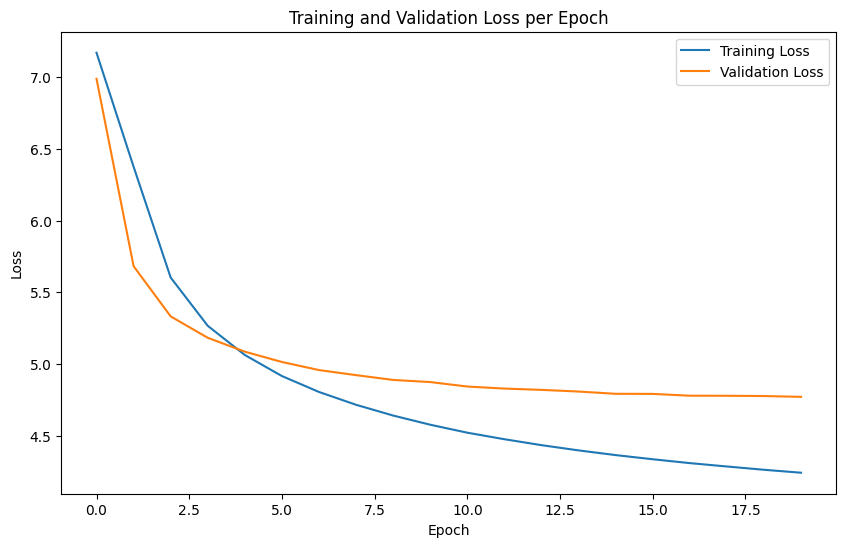

gru validation perplexity: 118.15434265136719


In [11]:
## Feel free to copy your original GRU solution down here to modify for your report if you'd like.
# YOUR CODE [optionally] HERE
##
import matplotlib.pyplot as plt
assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

device = torch.device("cuda")
import torch.optim as optim


def ids(tokens):
    return [vocab[t] for t in tokens]
class RecurrentLMDataset:
    def __init__(self, text_token_ids, bsz, bptt_len=32):
        self.bsz = bsz
        self.bptt_len = bptt_len
        token_ids = torch.tensor(text_token_ids)
        ncontig = token_ids.size(0) // bsz
        token_ids = token_ids[:ncontig*bsz].view(bsz, -1) # batch_size x ncontig
        self.token_ids = token_ids.t().contiguous() # ncontig x batch_size

    def __len__(self):
        return int(math.ceil(self.token_ids.size(0) / self.bptt_len))

    def __iter__(self):
        for i in range(0, self.token_ids.size(0)-1, self.bptt_len):
            seqlen = min(self.bptt_len, self.token_ids.size(0) - i - 1)
            x = self.token_ids[i:i+seqlen] # seqlen x batch_size
            y = self.token_ids[i+1:i+seqlen+1] # seqlen x batch_size
            yield x, y

# Hyperparameters
batch_size = 64
n_epochs = 15
bptt_len = 32
n_layers = 2
hidden_size = 768
embed_size = 128
clip = 5.


class GRUNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self, batch_size = 64, n_epochs = 15, bptt_len = 32, n_layers = 2, hidden_size = 768, embed_size = 128, clip = 5):
        super().__init__()

        # You will need to use a torch.nn.GRU layer in addition to torch.nn.Linear
        # and torch.nn.Dropout layers.

        # YOUR CODE HERE
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.bptt_len = bptt_len
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.clip = clip

        self.gru = nn.GRU(input_size = self.embed_size, hidden_size= self.hidden_size,
                          num_layers = self.n_layers, dropout= 0.3)

        self.dropout = nn.Dropout(p = 0.3)

        self.preout = nn.Linear(self.hidden_size, self.embed_size)
        self.out = nn.Linear(self.embed_size, vocab_size)


    def forward(self, x, state):
        """Compute the output of the network.

        Note: In the Pytorch GRU tutorial, the state variable is named "hidden":
        https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

        The torch.nn.GRU documentation is quite helpful:
        https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU

        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the GRU.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the GRU with the same sized tensors
            as the state tuple provided as input.
        """

        # Note that the nn.GRU module expects inputs with the sequence
        # dimension before the batch by default.
        # In this case the dimensions are already in the right order,
        # but watch out for this since sometimes people put the batch first

        # you can again use torch.nn.functional.embedding to convert input token
        # ids to embeddings looked up from the output layer's .weight tensor.

        # make sure you use .detach() before returning the state tuple

        # use torch.nn.functional.log_softmax for computing log-probabilities.

        # YOUR CODE HERE
        embedded = F.embedding(x, self.out.weight) ### (seq_len, batch) -> (seq_len, batch, embedding_dim)
        gruout, state = self.gru(embedded, state) ### (seq_len, batch, embedding_dim), (num_layers, batch, hidden_size)-> (seq_len, batch, hidden_size), (num_layers, batch, hidden_size)
        pre = self.preout(gruout) # preout takes (*, hidden_size) -> (*, embed_size) where * is any # of dimensions so we should be good
        predrop = self.dropout(pre)
        output = self.out(predrop) # out takes embed_size -> vocab_size
        lps = F.log_softmax(output, dim = -1)
        state = state.detach()
        return lps, state


class GRUModel:
    "A class that wraps GRUNetwork to handle training and evaluation."

    def __init__(self, batch_size = 64, n_epochs = 15, bptt_len = 32, n_layers = 2, hidden_size = 768, embed_size = 128, clip = 5):
        self.network = GRUNetwork(batch_size, n_epochs, bptt_len, n_layers, hidden_size, embed_size, clip).to(device)

    def train(self):
        rnn_lm_dataset = RecurrentLMDataset(ids(train_text), batch_size, bptt_len)
        # Obtain an iterator over rnn_lm_dataset by calling `iter(rnn_lm_dataset)`
        # or by using tqdm. Looping thru this iterator with a for loop gives (x, y) tuples,
        # where x is a seqlen x batch_size token id tensor, and y is a seqlen x batch_size token id tensor.
        # The token ids in y are the next word targets for the sequence up till that position
        # in x.
        clip_value = self.network.clip

        # The initial state passed into the GRU should be set to zero.

        # You can use gradient clipping before calling optimizer.step() as follows:
        # torch.nn.utils.clip_grad_norm_(
        #     [p for group in optimizer.param_groups for p in group['params']], clip_value)
        optimizer = optim.Adam(self.network.parameters(), weight_decay = 1e-5)
        loss_function = nn.NLLLoss()
        hidden_state = None

        # YOUR CODE HERE
        self.network.train()
        prev_perplexity = float('inf')
        train_losses = []
        val_losses = []
        for epoch in range(self.network.n_epochs):
            print('Epoch', epoch)
            train_loss_epoch = 0
            for batch in tqdm.tqdm_notebook(rnn_lm_dataset, leave=False):
              x, y = batch # x,y = (seqlen x batch_size) want to predict next word ys from x
              #### add stuff here
              x, y = x.cuda(), y.cuda()
              optimizer.zero_grad()
              if hidden_state is not None:
                hidden_state = hidden_state.detach()
              else:
                hidden_state = torch.zeros(self.network.n_layers, self.network.batch_size, self.network.hidden_size)
              hidden_state = hidden_state.cuda()
              nwps, hidden_state = self.network.forward(x, hidden_state)
              hidden_state = hidden_state.detach()
              nwps_flat = nwps.view(-1, nwps.size(2))  # Flatten batch and seq_len dimensions
              y_flat = y.view(-1)  # Flatten batch and seq_len dimensions
              loss = loss_function(nwps_flat, y_flat)
              train_loss_epoch += loss.item()
              loss.backward()
              torch.nn.utils.clip_grad_norm_(
                  [p for group in optimizer.param_groups for p in group['params']], clip_value)
              optimizer.step()
            train_loss_epoch /= len(rnn_lm_dataset)
            train_losses.append(train_loss_epoch)


            val_loss_epoch = self.val_avg_loss(validation_text)
            val_losses.append(val_loss_epoch)
            ep = self.perplexity(validation_text)
            if ep > prev_perplexity:
              break
            print('Epoch: ', epoch, ' Perplexity: ', ep)
        self.plot_losses(train_losses, val_losses)

    def plot_losses(self, train_losses, val_losses):
            "Plot the training and validation losses."
            plt.figure(figsize=(10, 6))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss per Epoch')
            plt.legend()
            plt.show()

    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        # We won't be calling check_validity for GRUs so you don't need to
        # worry about an empty prefix.

        # Make sure you initialize the hidden states to zero and you return
        # probabilities instead of log-probabilities.

        # YOUR CODE HERE
        # don't forget self.network.eval()
        # don't forget to move tensors to the GPU
        self.network.eval()

        hidden_state = torch.zeros(self.network.n_layers, 1, self.network.hidden_size).cuda()

        token_ids = ids(text_prefix)
        prefix_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(1).to(device)
        with torch.no_grad():
          log_probs, _ = self.network.forward(prefix_tensor, hidden_state)
          probs = torch.exp(log_probs[-1]).squeeze(0).cpu()

        self.network.train()

        return probs

    def val_avg_loss(self, text):
        "Return perplexity as a float."
        # Your code should be very similar to next_word_probabilities, but
        # run in a loop over batches. Use torch.no_grad() for extra speed.

        # make sure you pass the hidden state from one batch to the next.

        valdataset = RecurrentLMDataset(ids(text), self.network.batch_size, self.network.bptt_len)

        # YOUR CODE HERE
        # don't forget self.network.eval()
        # don't forget to move tensors to the GPU
        self.network.eval()

        hidden_state = torch.zeros(self.network.n_layers, self.network.batch_size, self.network.hidden_size).cuda()

        with torch.no_grad():
          tl = 0
          tts = 0
          for batch in valdataset:
            prefix, token = batch
            prefix, token = prefix.cuda(), token.cuda()
            lps, hidden_state = self.network.forward(prefix, hidden_state)
            hidden_state = hidden_state.detach()
            loss = F.nll_loss(lps.view(-1, lps.size(2)), token.view(-1), reduction = 'sum').item()
            tl += loss
            tts += token.view(-1).size(dim = 0)
        ret = torch.tensor(tl / tts).item()

        self.network.train()
        return ret

    def perplexity(self, text):
        "Return perplexity as a float."
        # Your code should be very similar to next_word_probabilities, but
        # run in a loop over batches. Use torch.no_grad() for extra speed.

        # make sure you pass the hidden state from one batch to the next.

        valdataset = RecurrentLMDataset(ids(text), self.network.batch_size, self.network.bptt_len)

        # YOUR CODE HERE
        # don't forget self.network.eval()
        # don't forget to move tensors to the GPU
        self.network.eval()

        hidden_state = torch.zeros(self.network.n_layers, self.network.batch_size, self.network.hidden_size).cuda()

        with torch.no_grad():
          tl = 0
          tts = 0
          for batch in valdataset:
            prefix, token = batch
            prefix, token = prefix.cuda(), token.cuda()
            lps, hidden_state = self.network.forward(prefix, hidden_state)
            hidden_state = hidden_state.detach()
            loss = F.nll_loss(lps.view(-1, lps.size(2)), token.view(-1), reduction = 'sum').item()
            tl += loss
            tts += token.view(-1).size(dim = 0)
        perplexity = torch.exp(torch.tensor(tl / tts)).item()

        self.network.train()
        return perplexity

# GRUModel(n_layers = 3),
models = [GRUModel(n_layers = 3, n_epochs = 20)]
for gru_model in models:
  gru_model.train()
  print('gru validation perplexity:', gru_model.perplexity(validation_text))



In [12]:
print('gru validation perplexity:', gru_model.perplexity(validation_text))
save_truncated_distribution(gru_model, 'gru_predictions.npy')

gru validation perplexity: 118.15434265136719


  0%|          | 0/1000 [00:00<?, ?it/s]

saved gru_predictions.npy


### Submission

Upload a submission with the following files to Gradescope:
* proj_1.ipynb (rename to match this exactly)
* gru_predictions.npy (this should also include all improvements from your exploration)
* neural_trigram_predictions.npy
* trigram_kn_predictions.npy
* bigram_predictions.npy
* report.pdf

You can upload files individually or as part of a zip file, but if using a zip file be sure you are zipping the files directly and not a folder that contains them.

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.  Note that the test set perplexities shown by the autograder are on a different scale from your validation set perplexities due to selecting different text and truncating the distribution.  Don't worry if the values seem worse. We will compare your perplexity on the test set to our model's perplexity and assign a score based on that.